# TrackChain - Track Parameters

In [1]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import datetime
import os
from tqdm.notebook import tqdm
import math

In [2]:
### ------------------------------ ###
### -------- DIRECTORIES --------- ###
### ------------------------------ ###

dir_src = os.path.abspath('')
dir_root = os.path.dirname(dir_src)
dir_data = os.path.join(dir_root, 'data')
dir_plots = os.path.join(dir_root, 'plots')

In [3]:
### ------------------------------ ###
### ----------- VALUES ----------- ###
### ------------------------------ ###

rho_gon = np.pi / 200 # Conversion factor from gon to radians
rho_deg = np.pi / 180 # Conversion factor from degree to radians

sigma_dist_default = 50 # [mm]
sigma_tilt_default = 0.072 # [deg]
sigma_tilt_default_rad = sigma_tilt_default * rho_deg # [rad]

num_reps = int(1e6) # Number of repetitions for Monte Carlo simulation

h0 = 0 # Height level of first point

nominal_dist_lateral = 4.8

sbb_profile_dist = 4.8
width_track = 1.435 # [m] width of a SBB track

In [37]:
def monte_carlo_track_params(
    sigma_tilt:float,
    sigma_dist:float,
    dist_tot:float=9.6,
    nominal_dist:float=1.2,
    nominal_dist_lat:float=4.8,
    single_chain:bool=True) -> tuple[np.ndarray, np.ndarray]:
    '''
    Analysis of precision using a Monte Carlo simulation

    Parameters
    ----------
    sigma_tilt : Float
        Standard deviation for the tilt angles
    sigma_dist : Float
        Standard deviation for the distances
    dist_tot : Float, optional
        The total distance to be simulated. Defaults to 3 SBB track profiles
    nominal_dist : Float, optional
        The nominal distance between any two sensors in the chain
    nominal_dist_lat : Float, optional
        The nominal distance between any two sensors in the lateral configuration
        Not used of single_chain is False
    single_chain : Boolean, optional
        Decides whether a single chain with lateral sensors or two chains should be used

    Returns
    -------
    std_n : np.ndarray
        Array of standard deviations for the torsion
    std_pf : np.ndarray
        Array of standard deviations for the "Vertikale Pfeilhöhe"
    '''

    num_sensors = int(dist_tot // nominal_dist)
    num_sensors_lat = int(dist_tot // nominal_dist_lat) + 1
    num_points = num_sensors + 1

    # Create random observations for the distances and the angles
    r_dist = np.random.normal(nominal_dist * 1000, sigma_dist, (num_sensors, num_reps))
    r_ang = np.random.normal(0, sigma_tilt * rho_deg, (num_sensors, num_reps))

    # Height differences per point
    dh = r_dist * np.sin(r_ang)

    # Cumulative sum of height differences, last point unknown
    h = np.insert(np.cumsum(dh, axis=0), 0, np.zeros(num_reps), axis=0)
    h_sbb = h[::int(sbb_profile_dist//nominal_dist)]
    
    if single_chain:
        r_dist_sec = np.random.normal(width_track * 1000, sigma_dist, (num_sensors_lat, num_reps))
        r_ang_sec = np.random.normal(0, sigma_tilt * rho_deg, (num_sensors_lat, num_reps))
        
        dh_sec = r_dist_sec * np.sin(r_ang_sec)
        h_sec = h[::math.ceil(num_points / num_sensors_lat)] + dh_sec
        h_sbb_sec = h_sec[::int(sbb_profile_dist//nominal_dist_lat)]
    else:
        r_dist_sec = np.random.normal(nominal_dist * 1000, sigma_dist, (num_sensors, num_reps))
        r_ang_sec = np.random.normal(0, sigma_tilt * rho_deg, (num_sensors, num_reps))

        # Height differences per point
        dh_sec = r_dist_sec * np.sin(r_ang_sec)

        # Cumulative sum of height differences, last point unknown
        h_sec = np.insert(np.cumsum(dh_sec, axis=0), 0, np.zeros(num_reps), axis=0)
        h_sbb_sec = h_sec[::int(sbb_profile_dist//nominal_dist)]
    
    std_h_sbb = np.std(h_sbb, axis=1)
    
    h_sbb_avg = np.mean(np.array([h_sbb, h_sbb_sec]), axis=0)

    # Vertikale Pfeilhöhe
    pf_v = h_sbb[1:-1] - (h_sbb[:-2] + h_sbb[2:]) / 2

    # Überhöhung
    u = h_sbb - h_sbb_sec
    
    # Verwindung
    n = (u[1:] - u[:-1]) / sbb_profile_dist
    
    std_pf_v = np.std(pf_v, axis=1)
    std_n = np.std(n, axis=1)

    return std_n, std_pf_v

In [93]:
nominal_dist_list = [0.6, 1.2, 2.4, 4.8]
sigma_tilt = 0.036

std_n_list_single = []
std_pf_v_list_single = []
for nominal_dist in nominal_dist_list:
    stds = monte_carlo_track_params(sigma_tilt, sigma_dist_default, nominal_dist=nominal_dist)
    std_n_list_single.append(stds[0][0])
    std_pf_v_list_single.append(stds[1])

std_n_list_double = []
std_pf_v_list_double = []
for nominal_dist in nominal_dist_list:
    stds = monte_carlo_track_params(sigma_tilt, sigma_dist_default, nominal_dist=nominal_dist, single_chain=False)
    std_n_list_double.append(stds[0][0])
    std_pf_v_list_double.append(stds[1])
print('d_nom\t|\tPf_v\t|\tN')
print('\n'.join(f'{dist:>5}\t|\t{pf_v[0]:.3f}\t|\t{n:.3f}' for dist, pf_v, n in zip(nominal_dist_list, std_pf_v_list_single, std_n_list_single)))
print('\n'.join(f'{dist:>5}\t|\t{pf_v[0]:.3f}\t|\t{n:.3f}' for dist, pf_v, n in zip(nominal_dist_list, std_pf_v_list_double, std_n_list_double)))

ax1 = plt.subplot(211)
fig = ax1.get_figure()
fig.set_facecolor('white')
fig.set_size_inches(15, 15)
fig.suptitle('Standardabweichung bei variierender Distanz', fontsize='20')
plot1 = ax1.plot(nominal_dist_list, std_pf_v_list_single, color='blue', marker='o')[0]
ax1.set_title('Eine Kette mit Quersensoren')
ax1.set_xlabel('Nominale Distanz zwischen zwei Sensoren [m]')
ax1.set_ylabel('Standardabweichung [mm]')
ax1.set_xticklabels(nominal_dist_list)
ax1.set_xticks(nominal_dist_list)

ax2 = ax1.twinx()
plot2 = ax2.plot(nominal_dist_list, std_n_list_single, color='orange', marker='o')[0]
ax2.set_ylabel('Standardabweichung [‰]')

ax1.legend([plot1, plot2], ['Vertikale Pfeilhöhe', 'Verwindung'], loc='center left')

ax3 = fig.add_subplot(212)
plot3 = ax3.plot(nominal_dist_list, std_pf_v_list_double, color='blue', marker='o')[0]
ax3.set_xlabel('Nominale Distanz zwischen zwei Sensoren [m]')
ax3.set_ylabel('Standardabweichung [mm]')
ax3.set_title('Zwei Ketten an beiden ')
ax3.set_xticklabels(nominal_dist_list)
ax3.set_xticks(nominal_dist_list)

ax4 = ax3.twinx()
plot4 = ax4.plot(nominal_dist_list, std_n_list_double, color='orange', marker='o')[0]
ax4.set_ylabel('Standardabweichung [‰]')

ax3.legend([plot3, plot4], ['Vertikale Pfeilhöhe', 'Verwindung'])

plt.savefig(os.path.join(dir_plots, 'track_params_comparison.png'))
plt.close()

d_nom	|	Pf_v	|	N
  0.6	|	0.757	|	0.288
  1.2	|	1.068	|	0.309
  2.4	|	1.509	|	0.266
  4.8	|	2.132	|	0.266
  0.6	|	0.757	|	0.316
  1.2	|	1.067	|	0.444
  2.4	|	1.508	|	0.629
  4.8	|	2.132	|	0.889


C:\Users\m.halbheer\AppData\Local\Temp\ipykernel_9504\1706051808.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(nominal_dist_list)
C:\Users\m.halbheer\AppData\Local\Temp\ipykernel_9504\1706051808.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(nominal_dist_list)


## Correlation of measurements with temperature

In [6]:
### Import data
sensor_raw = pd.read_csv(
    os.path.join(dir_data, 'Sensors_raw.csv'),
    sep=';',
    header=0,
    parse_dates=[['Date', 'Time']],
    infer_datetime_format=True,
    usecols=['Point', 'Date', 'Time', 'tilt_x0'],
    index_col=('Point','Date_Time')
)

temperature = pd.read_csv(
    os.path.join(dir_data, 'Letzi_Temperatur.csv'),
    sep=';',
    header=None,
    names=['Date_Time', 'Temp'],
    parse_dates=[0],
    infer_datetime_format=True,
    index_col=0,
    usecols=[0,2]
)

0.8256111723148578 -0.8273461622113735 0.4383153926515486


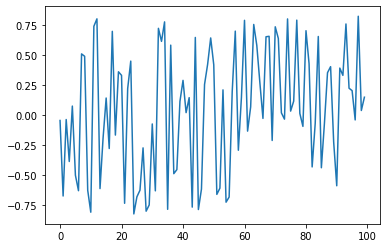

In [7]:
sample_delta = datetime.timedelta(minutes=30)
sensor_raw_resampled = sensor_raw.groupby(level=0).resample(sample_delta, level=1).mean()
temperature_resampled = temperature.resample(sample_delta).mean()

correlations = []

for sensor in sensor_raw_resampled.index.unique(level=0):
    sensor_raw_resampled_selected = sensor_raw_resampled.loc[sensor]

    max_start = max(min(temperature_resampled.index), min(sensor_raw_resampled_selected.index))
    min_end = min(max(temperature_resampled.index), max(sensor_raw_resampled_selected.index))

    sensor_raw_subsampled = sensor_raw_resampled_selected[(sensor_raw_resampled_selected.index >= max_start) & (sensor_raw_resampled_selected.index <= min_end)]
    temperature_subsampled = temperature_resampled[(temperature_resampled.index >= max_start) & (temperature_resampled.index <= min_end)]

    sensor_raw_singleday = sensor_raw_subsampled
    temperature_singleday = temperature_subsampled

    sensor_raw_singleday.merge(temperature_singleday, left_index=True, right_index=True).dropna(axis=0, how='any').corr()

    data_merged = sensor_raw_singleday.merge(temperature_singleday, left_index=True, right_index=True).dropna(axis='index', how='any')
    from scipy import stats
    outlier_filetered = data_merged[(np.abs(stats.zscore(data_merged)) < 3).all(axis=1)]
    correlations.append(outlier_filetered.corr().loc['tilt_x0']['Temp'])

print(max(correlations), min(correlations), np.mean(np.abs(correlations)))

## Simulate track parameters with two axis sensors at the center of the track

In [87]:
def monte_carlo_two_axis(
    sigma_tilt:float,
    sigma_dist:float,
    dist_tot:float=9.6,
    nominal_dist:float=1.2) -> tuple[np.ndarray, np.ndarray]:
    '''
    Analysis of precision using a Monte Carlo simulation

    Parameters
    ----------
    sigma_tilt : Float
        Standard deviation for the tilt angles
    sigma_dist : Float
        Standard deviation for the distances
    dist_tot : Float, optional
        The total distance to be simulated. Defaults to 3 SBB track profiles
    nominal_dist : Float, optional
        The nominal distance between any two sensors in the chain
    nominal_dist_lat : Float, optional
        The nominal distance between any two sensors in the lateral configuration
        Not used of single_chain is False
    single_chain : Boolean, optional
        Decides whether a single chain with lateral sensors or two chains should be used

    Returns
    -------
    std_n : np.ndarray
        Array of standard deviations for the torsion
    std_pf : np.ndarray
        Array of standard deviations for the "Vertikale Pfeilhöhe"
    '''

    num_sensors = int(dist_tot // nominal_dist) + 1
    num_points = num_sensors

    # Create random observations for the distances and the angles
    r_dist = np.random.normal(nominal_dist * 1000, sigma_dist, (num_sensors, num_reps))
    r_ang = np.random.normal(0, sigma_tilt * rho_deg, (num_sensors, num_reps))
    r_ang_lat = np.random.normal(0, sigma_tilt * rho_deg, (num_sensors, num_reps))
    r_dist_lat = np.random.normal(width_track / 2 * 1000, sigma_dist, (2, num_sensors, num_reps))

    # Height differences per point
    dh = r_dist * np.sin(r_ang)
    dh_lat = np.array([r_dist_lat[i] * np.sin(r_ang_lat) for i in range(r_dist_lat.shape[0])])

    # Cumulative sum of height differences, last point unknown
    h = np.cumsum(dh, axis=0)
    h_lat = h + dh_lat
    h_sbb = h_lat[:,::int(sbb_profile_dist//nominal_dist)]

    # Vertikale Pfeilhöhe
    pf_v = h_sbb[:, 1:-1] - (h_sbb[:, :-2] + h_sbb[:, 2:]) / 2

    # Überhöhung
    u = np.squeeze(np.diff(h_sbb, axis=0), axis=0)

    # Verwindung
    n = (u[1:] - u[:-1]) / sbb_profile_dist
    
    std_pf_v = np.std(pf_v, axis=2)
    std_n = np.std(n, axis=1)

    return std_n, std_pf_v

In [88]:
std_n_list_single = []
std_pf_v_list_single = []
for nominal_dist in nominal_dist_list:
    stds = monte_carlo_two_axis(sigma_tilt_default, sigma_dist_default, nominal_dist=nominal_dist)
    std_n_list_single.append(stds[0][0])
    std_pf_v_list_single.append(stds[1][0])

print('d_nom\t|\tPf_v\t|\tN')
print('\n'.join(f'{dist:>5}\t|\t{pf_v[0]:.3f}\t|\t{n:.3f}' for dist, pf_v, n in zip(nominal_dist_list, std_pf_v_list_single, std_n_list_single)))

ax1 = plt.subplot(111)
fig = ax1.get_figure()
fig.set_facecolor('white')
fig.set_size_inches(15, 15)
fig.suptitle('Standardabweichung bei variierender Distanz', fontsize='20')
plot1 = ax1.plot(nominal_dist_list, std_pf_v_list_single, color='blue', marker='o')[0]
ax1.set_title('Eine Kette mit Quersensoren')
ax1.set_xlabel('Nominale Distanz zwischen zwei Sensoren [m]')
ax1.set_ylabel('Standardabweichung [mm]')
ax1.set_xticklabels(nominal_dist_list)
ax1.set_xticks(nominal_dist_list)

ax2 = ax1.twinx()
plot2 = ax2.plot(nominal_dist_list, std_n_list_single, color='orange', marker='o')[0]
ax2.set_ylabel('Standardabweichung [‰]')

ax1.legend([plot1, plot2], ['Vertikale Pfeilhöhe', 'Verwindung'], loc='center left')

plt.savefig(os.path.join(dir_plots, 'track_params_comparison_two_axial.png'))
plt.close()

d_nom	|	Pf_v	|	N
  1.2	|	2.405	|	0.026
  2.4	|	3.209	|	0.026
  4.8	|	4.405	|	0.026


C:\Users\m.halbheer\AppData\Local\Temp\ipykernel_9504\171179006.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(nominal_dist_list)
